蒙特卡洛树搜索（Monte Carlo Tree Search，简称 MCTS）是一种用于决策过程中的搜索算法，它通过随机采样来估计某一决策的潜在结果。MCTS 最初应用于游戏领域，但现在也被广泛应用于其他需要决策搜索的场景，如机器人规划、人工智能和控制系统等。

<pre>MCTS 的优势:

    无需完整的游戏模型：MCTS 不需要了解完整的游戏状态空间，适用于那些状态空间巨大且难以完全探索的问题。
    平衡探索与利用：通过 UCB

等策略，MCTS 可以在探索新的决策路径和利用当前已知的信息之间取得平衡。
渐进式优化：随着模拟次数的增加，MCTS 的决策结果会逐渐趋向最优。
<pre>


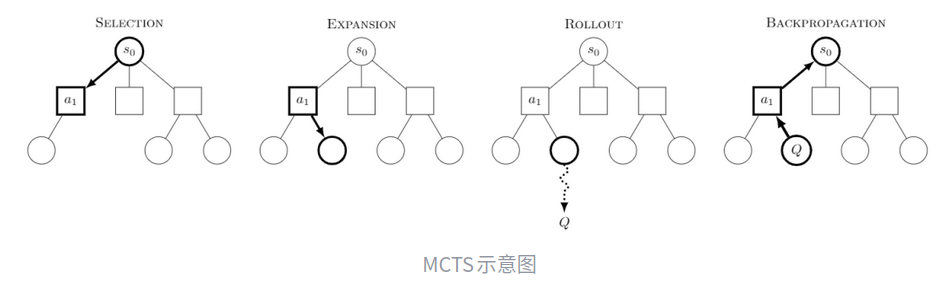

<pre>MCTS 的使用场景如下：

    游戏领域：MCTS 在棋类游戏（如围棋、国际象棋等）中表现优异。例如，Google DeepMind 的 AlphaGo 就使用了蒙特卡洛树搜索来进行决策，尤其是在围棋这种状态空间极其庞大的游戏中，MCTS 扮演了至关重要的角色。
    强化学习：在强化学习中，MCTS 可以用来寻找策略函数的最优解，通过在复杂环境中进行多次模拟，帮助代理智能体学习如何在未知环境中做出更好的决策。
    路径规划

：在机器人路径规划和自动驾驶领域，MCTS 可以用于寻找最优路径，通过不断模拟不同的路径选择，来实现最合适的路径规划。
决策支持系统

    ：在许多复杂的决策支持系统中，MCTS 可用于多目标优化，通过模拟各种决策结果，帮助用户找到最合适的解决方案。
    优化问题：MCTS 也可以用于各种组合优化问题，尤其是当问题的解空间庞大时，可以通过逐步模拟和调整来找到最优解。

MCTS原理

MCTS 的基本思想是利用蒙特卡洛方法和树结构的结合，在游戏或其他决策过程中，通过反复的模拟和计算，来找到最优的决策。

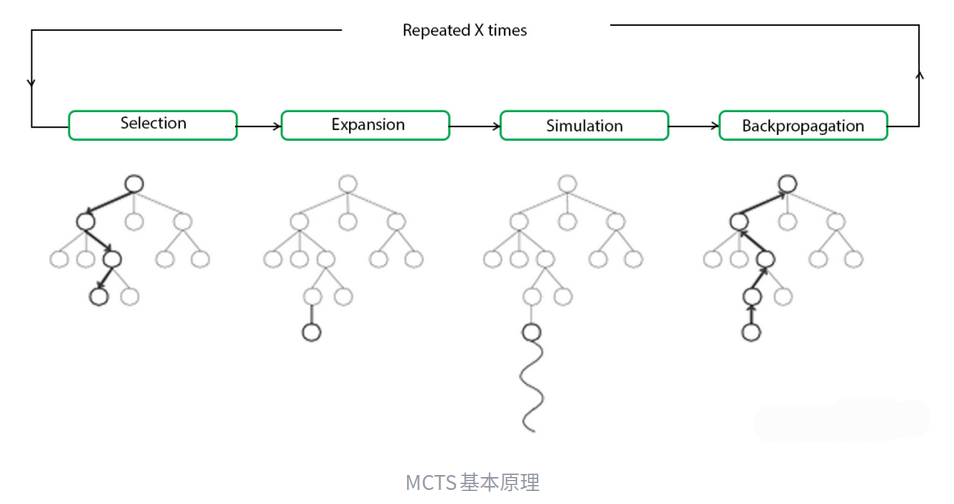

<pre>MCTS 算法通常由以下四个步骤组成：

    选择（Selection） 从当前树的根节点出发，沿着子节点逐层选择一个节点，直到到达一个未完全展开的节点或达到最大模拟深度为止。  
在这个过程中，选择最有可能导致最佳结果的节点，通常使用的是 UCB（上置信区间）策略。

    扩展（Expansion） 如果到达的节点不是终局节点（即没有子节点），则展开这个节点，生成一个或多个子节点。

    模拟（Simulation） 从扩展后的节点开始，进行一系列随机模拟，直到达到游戏的终局。模拟过程中的策略通常是随机的，可以是纯粹的随机选择。
    
    回溯（Backpropagation） 模拟结束后，将模拟结果（如胜负）回溯到树的每个节点。每个节点更新自己的统计数据，记录该节点的胜率或平均奖励。

这个过程会不断重复，逐步扩展树并优化决策结果。最终，选择拥有最高胜率的子节点作为当前的决策。
使用MCTS实现TicTacToe游戏

    Tic-Tac-Toe（井字游戏）是一款由两名玩家在 3x3 网格上交替标记 “X” 或 “O” 的简单游戏，目标是先在任意一行、列或对角线上形成连续的三个符号。玩家轮流选择空格并放置符号，若某玩家形成三连线，则获胜；若所有格子填满且无三连线，则游戏为平局。

游戏示意图如下：

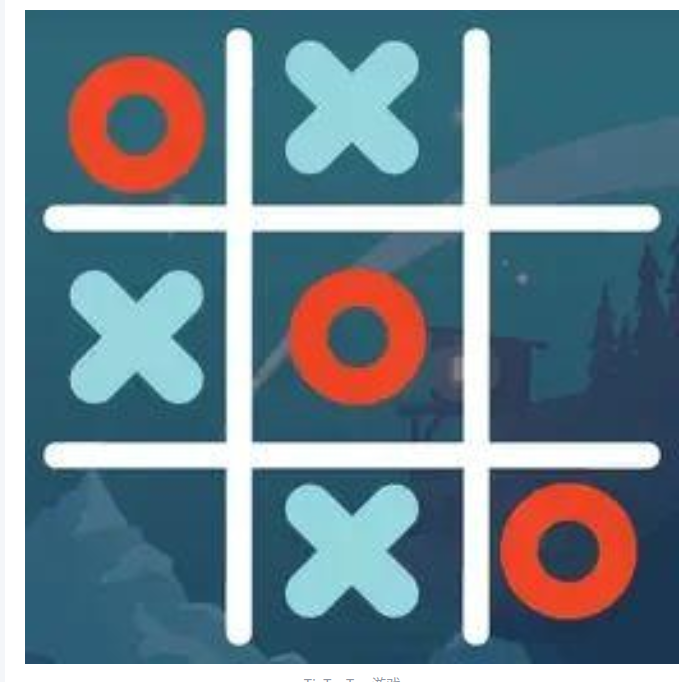

下面，我们将会使用Python实现TicTacToe游戏，博弈的双方为AI和玩家，玩家先走，AI采用MCTS思考策略，然后选择下棋的位置。

首先我们先实现MCTS类

In [2]:
from dataclasses import dataclass, field
from collections import defaultdict
import math
from typing import Dict, Set, List, Optional
from abc import ABC, abstractmethod


class Node(ABC):
    """Abstract base class for game state nodes."""

    @abstractmethod
    def find_children(self) -> Set["Node"]:
        """Return all possible child nodes."""

    @abstractmethod
    def get_random_child(self) -> Optional["Node"]:
        """Return a random child node."""

    @abstractmethod
    def is_terminal(self) -> bool:
        """Check if the node is a terminal state."""

    @abstractmethod
    def reward(self) -> float:
        """Return the reward value for a terminal node."""

    @abstractmethod
    def __hash__(self) -> int:
        """Define a hash function for the node."""

    @abstractmethod
    def __eq__(self, other: object) -> bool:
        """Define equality comparison for nodes."""


@dataclass
class MCTS:
    """Monte Carlo Tree Search implementation."""

    exploration_weight: float = 1.0
    total_rewards: Dict[Node, float] = field(default_factory=lambda: defaultdict(float))
    visit_counts: Dict[Node, int] = field(default_factory=lambda: defaultdict(int))
    children: Dict[Node, Set[Node]] = field(default_factory=lambda: defaultdict(set))

    def select_best_move(self, node: Node) -> Node:
        """Select the best move from the current node."""
        if node.is_terminal():
            raise ValueError(f"Cannot select move from terminal node: {node}")

        if node not in self.children:
            return node.get_random_child()

        return max(self.children[node], key=self._calculate_node_score)

    def simulate(self, node: Node) -> None:
        """Perform one iteration of the MCTS algorithm."""
        path = self._traverse_tree(node)
        leaf = path[-1]
        self._expand_node(leaf)
        reward = self._simulate_random_playout(leaf)
        self._backpropagate(path, reward)

    def _traverse_tree(self, node: Node) -> List[Node]:
        """Traverse the tree to find an unexplored node."""
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - set(self.children.keys())
            if unexplored:
                path.append(unexplored.pop())
                return path
            node = self._select_uct(node)

    def _expand_node(self, node: Node) -> None:
        """Expand the node by adding its children to the tree."""
        if node in self.children:
            return
        self.children[node] = node.find_children()

    def _simulate_random_playout(self, node: Node) -> float:
        """Simulate a random playout from the given node."""
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.get_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path: List[Node], reward: float) -> None:
        """Update the statistics for the nodes in the path."""
        for node in reversed(path):
            self.visit_counts[node] += 1
            self.total_rewards[node] += reward
            reward = 1 - reward

    def _select_uct(self, node: Node) -> Node:
        """Select a child node using the UCT formula."""
        assert all(n in self.children for n in self.children[node])
        log_n_parent = math.log(self.visit_counts[node])

        def uct(n: Node) -> float:
            return self.total_rewards[n] / self.visit_counts[
                n
            ] + self.exploration_weight * math.sqrt(log_n_parent / self.visit_counts[n])

        return max(self.children[node], key=uct)

    def _calculate_node_score(self, node: Node) -> float:
        """Calculate the score for a node based on its average reward."""
        if self.visit_counts[node] == 0:
            return float("-inf")
        return self.total_rewards[node] / self.visit_counts[node]

使用MCTS算法实现TicTacToe游戏

In [3]:
import random
from tabulate import tabulate
from typing import Set, Optional

class TicTacToeNode(Node):
    def __init__(self, state: str, player: str):
        self.state = state
        self.player = player

    def find_children(self) -> Set["TicTacToeNode"]:
        if self.is_terminal():
            return set()
        return {
            TicTacToeNode(
                self.state[:i] + self.player + self.state[i + 1:],
                "O" if self.player == "X" else "X",
            )
            for i, value in enumerate(self.state)
            if value == " "
        }

    def get_random_child(self) -> Optional["TicTacToeNode"]:
        if self.is_terminal():
            return None
        empty_spots = [i for i, value in enumerate(self.state) if value == " "]
        index = random.choice(empty_spots)
        return TicTacToeNode(
            self.state[:index] + self.player + self.state[index + 1:],
            "O" if self.player == "X" else "X",
        )

    def is_terminal(self) -> bool:
        return self.winner() is not None or " " not in self.state

    def reward(self) -> float:
        winner = self.winner()
        if winner is None:
            return 0.5  # Draw
        return 1.0 if winner == self.player else 0.0

    def __hash__(self) -> int:
        return hash(self.state)

    def __eq__(self, other: object) -> bool:
        return isinstance(other, TicTacToeNode) and self.state == other.state

    def winner(self) -> Optional[str]:
        lines = [
            (0, 1, 2),
            (3, 4, 5),
            (6, 7, 8),  # Rows
            (0, 3, 6),
            (1, 4, 7),
            (2, 5, 8),  # Columns
            (0, 4, 8),
            (2, 4, 6),  # Diagonals
        ]
        for line in lines:
            if self.state[line[0]] == self.state[line[1]] == self.state[line[2]] != " ":
                return self.state[line[0]]
        return None


def play_game():
    state = " " * 9
    mcts = MCTS()
    board = TicTacToeNode(state, "X")

    print("Initial board:")
    print_board(board.state)

    while True:
        # Human player's turn (O)
        human_move = int(input("Enter your move (0-8): "))
        board = TicTacToeNode(
            board.state[:human_move] + "O" + board.state[human_move + 1:], "X"
        )
        print("\nBoard after your move:")
        print_board(board.state)

        if board.is_terminal():
            break

        # AI player's turn (X)
        for _ in range(1000):  # Number of MCTS iterations
            mcts.simulate(board)
        board = mcts.select_best_move(board)
        print("\nBoard after AI move:")
        print_board(board.state)

        if board.is_terminal():
            break

    winner = board.winner()
    if winner:
        print(f"\nPlayer {winner} wins!")
    else:
        print("\nIt's a draw!")


def print_board(state: str):
    data = []
    for i in range(0, 9, 3):
        data.append(state[i: i + 3])
    print(tabulate(data, tablefmt="grid", headers=[]))

In [5]:
play_game()

Initial board:
+--+--+--+
|  |  |  |
+--+--+--+
|  |  |  |
+--+--+--+
|  |  |  |
+--+--+--+

Board after your move:
+---+--+--+
| O |  |  |
+---+--+--+
|   |  |  |
+---+--+--+
|   |  |  |
+---+--+--+

Board after AI move:
+---+---+--+
| O |   |  |
+---+---+--+
|   | X |  |
+---+---+--+
|   |   |  |
+---+---+--+

Board after your move:
+---+---+--+
| O | O |  |
+---+---+--+
|   | X |  |
+---+---+--+
|   |   |  |
+---+---+--+

Board after AI move:
+---+---+---+
| O | O | X |
+---+---+---+
|   | X |   |
+---+---+---+
|   |   |   |
+---+---+---+

Board after your move:
+---+---+---+
| O | O | O |
+---+---+---+
|   | X |   |
+---+---+---+
|   |   |   |
+---+---+---+

Player O wins!


TicTacToe游戏的可视化版本

In [6]:
import tkinter as tk
from tkinter import messagebox
import random
class TicTacToe:
    def __init__(self, root):
        self.root = root
        self.root.title("Tic Tac Toe")

        self.board = [[None] * 3 for _ in range(3)]
        self.current_player = "X"  # Player always starts

        self.frame = tk.Frame(self.root)
        self.frame.pack()

        self.buttons = [[tk.Button(self.frame, text="", font=("Arial", 24), width=5, height=2,
                                   command=lambda r=r, c=c: self.make_move(r, c))
                         for c in range(3)] for r in range(3)]

        for r in range(3):
            for c in range(3):
                self.buttons[r][c].grid(row=r, column=c)

        self.start_button = tk.Button(self.root, text="Start", font=("Arial", 14), command=self.reset_game)
        self.start_button.pack(pady=10)

    def make_move(self, row, col):
        if self.buttons[row][col]["text"] == "":  # Check if cell is empty
            self.buttons[row][col]["text"] = self.current_player
            self.board[row][col] = self.current_player

            if self.check_winner():
                messagebox.showinfo("Game Over", f"{self.current_player} Wins!")
                self.disable_buttons()
                return
            elif all(all(cell is not None for cell in row) for row in self.board):
                messagebox.showinfo("Game Over", "It's a Draw!")
                return

            self.current_player = "O" if self.current_player == "X" else "X"  # Switch player
            if self.current_player == "O":
                self.computer_move()

    def computer_move(self):
        empty_cells = [(r, c) for r in range(3) for c in range(3) if self.board[r][c] is None]
        # print(self.board)
        # random move
        # if empty_cells:
        #     row, col = random.choice(empty_cells)
        #     self.make_move(row, col)
        # move by MCTS
        mcts = MCTS()
        state = "".join(cell if cell is not None else " " for row in self.board for cell in row)
        board = TicTacToeNode(state, "O")
        for _ in range(1000):  # Number of MCTS iterations
            mcts.simulate(board)
        board = mcts.select_best_move(board)
        # get new board as 3 * 3 and replace empty string as None
        new_board = [[cell if cell != " " else None for cell in board.state[i:i + 3]] for i in range(0, 9, 3)]
        # print(new_board)
        # get move position
        row, col = None, None
        for r in range(3):
            for c in range(3):
                if new_board[r][c] != self.board[r][c]:
                    row, col = r, c
                    break

        if row is not None:
            self.make_move(row, col)

    def check_winner(self):
        for i in range(3):
            if self.board[i][0] == self.board[i][1] == self.board[i][2] and self.board[i][0] is not None:
                return True  # Row match
            if self.board[0][i] == self.board[1][i] == self.board[2][i] and self.board[0][i] is not None:
                return True  # Column match

        if self.board[0][0] == self.board[1][1] == self.board[2][2] and self.board[0][0] is not None:
            return True  # Diagonal match
        if self.board[0][2] == self.board[1][1] == self.board[2][0] and self.board[0][2] is not None:
            return True  # Anti-diagonal match

        return False

    def disable_buttons(self):
        for r in range(3):
            for c in range(3):
                self.buttons[r][c]["state"] = "disabled"

    def reset_game(self):
        self.board = [[None] * 3 for _ in range(3)]
        self.current_player = "X"
        for r in range(3):
            for c in range(3):
                self.buttons[r][c]["text"] = ""
                self.buttons[r][c]["state"] = "normal"

In [7]:
root = tk.Tk()
game = TicTacToe(root)
root.mainloop()